In [1]:
import os

import pickle
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy_indexed as npi
from scipy.io import loadmat

from src.ipm import NeuronLoader, grablabels
from src.metrics import sepind

from imblearn.under_sampling import RandomUnderSampler as rus
from scipy.ndimage import gaussian_filter1d as smooth

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import recall_score

In [2]:
fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

In [3]:
with open("./src/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
info.head()

,img,sfr,con,sup,mid,fac,bod,art,nat,cat
0,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face
1,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face part,none,none,False,False,False,False,none
2,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face
3,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,misc,none,none,False,False,False,False,none
4,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face


In [ ]:
fast = {
    'it': np.load(r"G:\Data\Paired\Zebel\fast-it.npy"),
    'pfc': np.load(r"G:\Data\Paired\Zebel\fast-pfc.npy"),
}

slow = {
    'it': np.load(r"G:\Data\Paired\Zebel\slow-it.npy"),
    'pfc': np.load(r"G:\Data\Paired\Zebel\slow-pfc.npy"),
}

# Categorization

## Model Fitting

In [ ]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    
    inds, X, y, l = [], [], [], []
    for i, g in enumerate(np.unique(groups)):
        if 'none'==g:
            continue

        inds.append(np.random.choice(np.argwhere(groups==g).squeeze(), size=n, replace=False))
        X.extend(data[inds[-1]])
        y.extend(i * np.ones_like(inds[-1]))
        l.append(g)
    
    X, y = np.array(X), np.array(y)
    rind = np.random.permutation(X.shape[0])
    X, y = X[rind], y[rind]
    return X, y, l

In [ ]:
nmb_component = .95
nmb_rep = 200

for monkey in ["both", "jenab", "zebel"]:
    for selectivity in ["fast", "slow"]:
        data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')
        time_bins = np.arange(data.it.shape[2], step=5)
        
        out_path  = f'G:\\Codes\\Processing\\out\\svmc\\{monkey.lower()}-{selectivity.lower()}'
        os.makedirs(out_path, exist_ok=True)
        
        for region in ['it', 'pfc']:
            region_data = data.it if region=='it' else data.pfc
            
            nmb_smp = info['cat'].groupby(info['cat']).count().drop('none').values.min()
            nmb_cls = info['cat'].groupby(info['cat']).count().drop('none').size
            nmb_bin = time_bins.size
            
            cfn = np.nan * np.ones([nmb_cls, nmb_cls, nmb_bin, nmb_rep])
            rec = np.nan * np.ones([nmb_cls, nmb_bin, nmb_rep])
            
            for seed in (pbar := tqdm(range(nmb_rep))):
                pbar.set_description(monkey+"-"+selectivity+"-"+region)
                X, y, l = mkeqdata(region_data, info['cat'].to_numpy(), nmb_smp, seed=seed)

                for biter, ibin in enumerate(time_bins):
                    # pca = PCA(n_components=None if nmb_component==-1 else nmb_component, 
                    #           copy=True, whiten=False, svd_solver='auto', random_state=seed)
                    # Xr = pca.fit_transform(X[:,:,ibin])
                    Xr = X[:,:,ibin]
                    X_train, X_test, y_train, y_test = tts(Xr, y, test_size=.3,
                                                           random_state=seed, shuffle=True, stratify=y)
                    mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', 
                                                              random_state=seed)).fit(X_train, y_train)
                        
                    cfn[:,:,biter,seed] = confusion_matrix(y_test, mdl.predict(X_test), labels=np.arange(nmb_cls), sample_weight=None, normalize=None)
                    rec[:,biter,seed]   = recall_score(y_test, mdl.predict(X_test), average=None)
            
            prefix = f"{region}"
            np.save(os.path.join(out_path, prefix + '-cfn.npy'), cfn)
            np.save(os.path.join(out_path, prefix + '-rec.npy'), rec)
            with open(os.path.join(out_path, prefix + '-meta.npy'), "wb") as handler:
                pickle.dump({'labels': l, 'time': data.time[time_bins]}, handler)

## Visualization


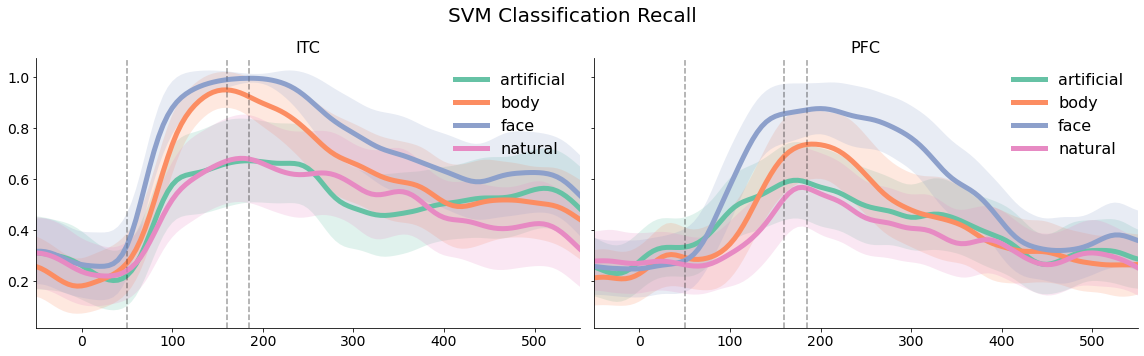

In [4]:
%matplotlib inline
plt.ion()

monkey = "both"
selectivity = "fast"
out_path  = f'G:\\Codes\\Processing\\out\\svmc\\{monkey.lower()}-{selectivity.lower()}'

import pickle
with open(f"{out_path}\\it-meta.npy", "rb") as handler:
    meta = pickle.load(handler)
itc = np.load(os.path.join(out_path, "it" + '-rec.npy'))
pfc = np.load(os.path.join(out_path, "pfc" + '-rec.npy'))

itc = smooth(itc, 3, axis=1)
pfc = smooth(pfc, 3, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

for ax, rec, reg in zip(axs, [itc, pfc], ["ITC", "PFC"]):
    for r in rec:
        ax.plot(meta['time'], r.mean(1).T, lw=5)
        ax.fill_between(meta['time'], 
                        r.mean(1) - r.std(1), 
                        r.mean(1) + r.std(1),
                        alpha=.2)
        ax.legend(meta['labels'], frameon=False, fontsize=16)
        ax.axvline(185, color='k', linestyle='--', label='_nolegend_', alpha=0.1)
        ax.axvline(50, color='k', linestyle='--', label='_nolegend_', alpha=0.1)
        ax.axvline(160, color='k', linestyle='--', label='_nolegend_', alpha=0.1)
        ax.set_title(reg, fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(-50, 550)

# ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
#             xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
#             xycoords='data', fontsize=18, 
#             horizontalalignment='center',
#             verticalalignment=va)
sns.despine()

fig.suptitle("SVM Classification Recall", fontsize=20)
fig.tight_layout()
plt.savefig(os.path.join(out_path, 'recall.jpg'), dpi=1200)

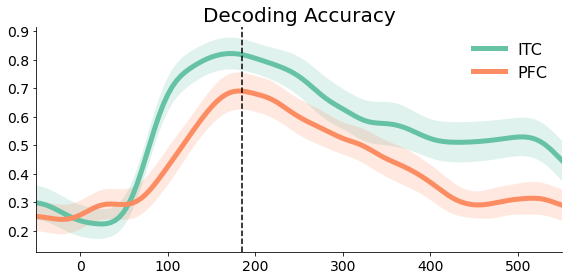

In [5]:
monkey = "both"
selectivity = "fast"
out_path  = f'G:\\Codes\\Processing\\out\\svmc\\{monkey.lower()}-{selectivity.lower()}'

import pickle
with open(f"{out_path}\\it-meta.npy", "rb") as handler:
    meta = pickle.load(handler)
itc = np.load(os.path.join(out_path, "it" + '-cfn.npy'))
pfc = np.load(os.path.join(out_path, "pfc" + '-cfn.npy'))

itc = np.diagonal(itc, axis1=0, axis2=1).sum(-1) / itc.sum((0, 1))
pfc = np.diagonal(pfc, axis1=0, axis2=1).sum(-1) / pfc.sum((0, 1))

itc = smooth(itc, 3, axis=0)
pfc = smooth(pfc, 3, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for reg in [itc, pfc]:
    ax.plot(meta['time'], reg.mean(1), lw=5)
    ax.fill_between(meta['time'],
                    reg.mean(1) - reg.std(1),
                    reg.mean(1) + reg.std(1),
                    alpha=.2)

ax.legend(["ITC", "PFC"], frameon=False, fontsize=16)
ax.axvline(185, color='k', linestyle='--', label='_nolegend_')
ax.set_title("Decoding Accuracy", fontsize=20)
ax.set_xlim(-50, 650)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(-50, 550)

sns.despine()

fig.tight_layout()
plt.savefig(os.path.join(out_path, 'accuracy.png'), dpi=1200)